# Model: XGBoost

### Importing Libraries

In [1]:
import _pickle as pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

### Loading in Data

In [2]:
with open("top10_corr_df.pkl",'rb') as fp:
    df = pickle.load(fp)

### Scaling the Data

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features_df = df.drop(["Decision"], 1)

scaled_df = pd.DataFrame(scaler.fit_transform(features_df), 
                               index=features_df.index, 
                               columns=features_df.columns)

df = scaled_df.join(df.Decision)

### Splitting the Data

In [4]:
X = df.drop(["Decision"], 1)
y = df.Decision

# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Helper Functions

#### Function for plotting confusion matrix

In [5]:
def plot_confusion_matrix(y_true, y_pred, labels=["Sell", "Buy", "Hold"], 
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

## Modeling
The preferred evaluation metric used will be __Precision__ for each class.  They will be optimized using the __F1 Score-Macro-Average__ to balance the Precision and Recall.  This is done because we want to not only be correct when predicting but also make a decent amount of predictions for each class.  Classes such as 'Buy' and 'Sell' are more important than 'Hold'.

### Fitting and Training

In [6]:
# Preventing error from occuring: XGBoost causes kernel to die.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import xgboost as xgb

In [7]:
# Instatiating the model classifier
clf = xgb.XGBClassifier()

# Fitting to the Data
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

### Printing out Evaluation Metrics

In [8]:
# Classifier predictions
pred = clf.predict(X_test)

#Printing out results
report = classification_report(y_test, pred, target_names=['Sell', 'Buy', 'Hold'])
print(report)

              precision    recall  f1-score   support

        Sell       0.43      0.01      0.02      2907
         Buy       0.47      0.31      0.38      5581
        Hold       0.46      0.79      0.58      6555

   micro avg       0.46      0.46      0.46     15043
   macro avg       0.46      0.37      0.33     15043
weighted avg       0.46      0.46      0.40     15043



### Confusion Matrix

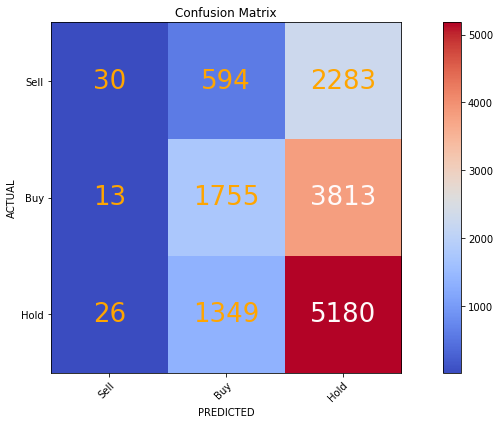

In [9]:
plot_confusion_matrix(y_test, pred, title="Confusion Matrix")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.show()

## Tuning Model Parameters

In [10]:
from sklearn.model_selection import GridSearchCV

### Parameters

In [11]:
# Parameters to tune
params = {"booster": ["gbtree", "gblinear", 'dart'],
          "eta": [.1, .5, .9],
          "gamma": [0, 1, 3],
          "n_estimators": [50, 100, 200],
          "max_depth": [1, 3, 6],
          "grow_policy": ['depthwise', 'lossguide']}

In [12]:
search = GridSearchCV(clf, params, cv=3, return_train_score=True, verbose=5, scoring='f1_macro')

search.fit(X,y)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.31659875302852986, total=   5.3s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.30292026107029785, total=   5.8s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s


[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.3088177905910068, total=   5.2s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.7s remaining:    0.0s


[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.31985856064775836, total=  11.3s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.2s remaining:    0.0s


[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.3106569508355601, total=  12.3s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.31553557218595557, total=  11.9s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.32408244130020797, total=  24.1s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.3163301874500038, total=  20.6s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=2

[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=100, score=0.3234763834412935, total=  26.9s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.33333177955726007, total=  55.0s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.32498230534896144, total=  56.0s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.3256417590445115, total=  55.2s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=50

[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.334404494586531, total= 1.6min
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.3304902257860483, total= 1.6min
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.33299321161156237, total= 1.7min
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.31659875302852986, total=   6.7s
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=50, s

[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.3162157221979928, total=  30.7s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.3165567035532016, total=  26.8s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.32429952959227215, total=  13.6s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3146513520907136, total=  13.5s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50, sco

[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.32053979866997667, total=  33.3s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.32986038200782775, total=  16.0s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.3233652556735051, total=  15.6s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.3296369819579102, total=  16.0s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=100, sc

[CV]  booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.31659875302852986, total=   4.2s
[CV] booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.30292026107029785, total=   4.2s
[CV] booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.3088177905910068, total=   4.4s
[CV] booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.31985856064775836, total=   8.5s
[CV] booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100, 

[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3151557734181248, total=  10.8s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3192831556695865, total=  11.6s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.32840224877187946, total=  16.6s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.3203400424031981, total=  22.3s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100, 

[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.3291095730436138, total=  11.6s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.3336565776447257, total=  21.1s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.3268988858681811, total=  21.0s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.33331647432137973, total=  24.0s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200

[CV]  booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.3196853953482541, total=   5.8s
[CV] booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.3106569508355601, total=   5.8s
[CV] booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.3149740162750064, total=   5.9s
[CV] booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.32386097217698956, total=  11.9s
[CV] booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=20

[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.32031040327111016, total=  13.8s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.3234763834412935, total=  11.4s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.33333177955726007, total=  23.9s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.32498230534896144, total=  23.7s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=

[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.3316966541281536, total=  21.1s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.33585243958572436, total=  41.7s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.3323369181897273, total=  41.9s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.3374209160145174, total=  43.8s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50,

[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.32408244130020797, total=  11.2s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.3163301874500038, total=  11.6s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.31716811663461736, total=  11.5s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.3248673566466492, total=   6.3s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, 

[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.3170773737043608, total=  24.9s
[CV] booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.32053979866997667, total=  23.9s
[CV] booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.32986038200782775, total=  11.4s
[CV] booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.3233652556735051, total=  12.0s
[CV] booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50, sc

[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.3294171660647191, total=  44.2s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.2056692038312974, total=   1.9s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20450196327091316, total=   1.9s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20452087990995382, total=   1.9s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_es

[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20452087990995382, total=   7.4s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.2056692038312974, total=   2.2s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20450196327091316, total=   2.3s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20452087990995382, total=   2.1s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n

[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20452087990995382, total=   7.8s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.2056692038312974, total=   2.0s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20450196327091316, total=   2.1s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20452087990995382, total=   1.9s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n

[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20452087990995382, total=   7.3s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.2056692038312974, total=   1.9s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20450196327091316, total=   1.9s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20452087990995382, total=   1.9s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n

[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20452087990995382, total=   7.5s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.2056692038312974, total=   1.9s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20450196327091316, total=   1.9s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20452087990995382, total=   1.9s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n

[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20452087990995382, total=   7.5s
[CV] booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.2056692038312974, total=   1.9s
[CV] booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20450196327091316, total=   1.9s
[CV] booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20452087990995382, total=   1.9s
[CV] booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=6, n

[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20452087990995382, total=   7.4s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.2056692038312974, total=   2.0s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20450196327091316, total=   1.9s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20452087990995382, total=   1.9s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=1, n

[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20452087990995382, total=   7.4s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.2056692038312974, total=   1.9s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20450196327091316, total=   1.9s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20452087990995382, total=   1.9s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n

[CV]  booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20452087990995382, total=   7.4s
[CV] booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.2056692038312974, total=   1.9s
[CV] booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20450196327091316, total=   1.9s
[CV] booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20452087990995382, total=   1.9s
[CV] booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n

[CV]  booster=gblinear, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20452087990995382, total=   7.7s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.2056692038312974, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20450196327091316, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20452087990995382, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n

[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20452087990995382, total=   9.1s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.2056692038312974, total=   2.0s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20450196327091316, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20452087990995382, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n

[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20452087990995382, total=   7.3s
[CV] booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.2056692038312974, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20450196327091316, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20452087990995382, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n

[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20452087990995382, total=   7.3s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.2056692038312974, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20450196327091316, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20452087990995382, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n

[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20452087990995382, total=   7.3s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.2056692038312974, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20450196327091316, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20452087990995382, total=   1.9s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n

[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.3302133508567158, total=  19.1s
[CV] booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.32328457376895264, total=  18.6s
[CV] booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.33002784183085204, total=  18.8s
[CV] booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=100, score=0.33287388036989624, total=  59.2s
[CV] booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=100, score=0.3279422365

[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.30292026107029785, total=   3.9s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.3088177905910068, total=   3.9s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.31985856064775836, total=  11.4s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.3106569508355601, total=  11.4s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.315535572

[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.3192831556695865, total=   9.1s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=100, score=0.32840224877187946, total=  27.1s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=100, score=0.3203400424031981, total=  26.8s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=100, score=0.3239564426642048, total=  29.2s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.33233110

[CV]  booster=dart, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=100, score=0.3317754594753131, total=  53.5s
[CV] booster=dart, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=100, score=0.32656844871333024, total=  53.2s
[CV] booster=dart, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=100, score=0.3293711930129089, total=  51.5s
[CV] booster=dart, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.3318192013112562, total= 2.4min
[CV] booster=dart, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.3262137

[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.3106569508355601, total=  11.7s
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.31553557218595557, total=  11.8s
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.32408244130020797, total=  42.2s
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.3163301874500038, total=  41.9s
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.317168

[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=100, score=0.3234763834412935, total=  28.9s
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.33333177955726007, total= 1.6min
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.32498230534896144, total= 1.6min
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.3256417590445115, total= 1.6min
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.33021335

[CV]  booster=dart, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.334404494586531, total= 3.5min
[CV] booster=dart, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.3304902257860483, total= 3.3min
[CV] booster=dart, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.33299321161156237, total= 3.3min
[CV] booster=dart, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.31659875302852986, total=   4.1s
[CV] booster=dart, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.30292026107

[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.3162157221979928, total=  38.6s
[CV] booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.3165567035532016, total=  37.8s
[CV] booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.32429952959227215, total=   8.6s
[CV] booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3146513520907136, total=   8.5s
[CV] booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3178697836079

[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.32053979866997667, total= 1.1min
[CV] booster=dart, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.32986038200782775, total=  18.9s
[CV] booster=dart, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.3233652556735051, total=  18.7s
[CV] booster=dart, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.3296369819579102, total=  19.0s
[CV] booster=dart, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.331775459475

[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.31659875302852986, total=   4.2s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.30292026107029785, total=   4.0s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.3088177905910068, total=   4.1s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.31985856064775836, total=  11.9s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.3106569508

[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3151557734181248, total=   9.3s
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3192831556695865, total=   9.0s
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.32840224877187946, total=  27.3s
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.3203400424031981, total=  26.9s
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.3239564426

[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.3291095730436138, total=  19.5s
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.3336565776447257, total= 1.0min
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.3268988858681811, total= 1.0min
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.33331647432137973, total= 1.0min
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.33440449

[CV]  booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.3196853953482541, total=  11.9s
[CV] booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.3106569508355601, total=  11.7s
[CV] booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.3149740162750064, total=  11.7s
[CV] booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.32386097217698956, total=  40.4s
[CV] booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.3162157

[Parallel(n_jobs=1)]: Done 1458 out of 1458 | elapsed: 876.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'booster': ['gbtree', 'gblinear', 'dart'], 'eta': [0.1, 0.5, 0.9], 'gamma': [0, 1, 3], 'n_estimators': [50, 100, 200], 'max_depth': [1, 3, 6], 'grow_policy': ['depthwise', 'lossguide']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=5)

### Tuned Results

In [13]:
print("Mean Training Score:", np.mean(search.cv_results_['mean_train_score']))
print("Mean Testing Score:", search.score(X, y))
print("\nBest Parameter Found:")
search.best_params_

Mean Training Score: 0.30331704927143194
Mean Testing Score: 0.4363755521655656

Best Parameter Found:


{'booster': 'gbtree',
 'eta': 0.1,
 'gamma': 0,
 'grow_policy': 'depthwise',
 'max_depth': 6,
 'n_estimators': 200}

### Model with the Best Parameters

In [14]:
search_clf = search.best_estimator_

search_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
       grow_policy='depthwise', learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

#### Results from Optimum Parameters

In [15]:
# Classifier predictions
s_pred = search_clf.predict(X_test)

#Printing out results
report = classification_report(y_test, s_pred, target_names=['Sell', 'Buy', 'Hold'])
print(report)

              precision    recall  f1-score   support

        Sell       0.30      0.02      0.04      2907
         Buy       0.45      0.34      0.39      5581
        Hold       0.46      0.74      0.57      6555

   micro avg       0.46      0.46      0.46     15043
   macro avg       0.41      0.37      0.33     15043
weighted avg       0.43      0.46      0.40     15043



### Confusion Matrix for Optimum Parameters

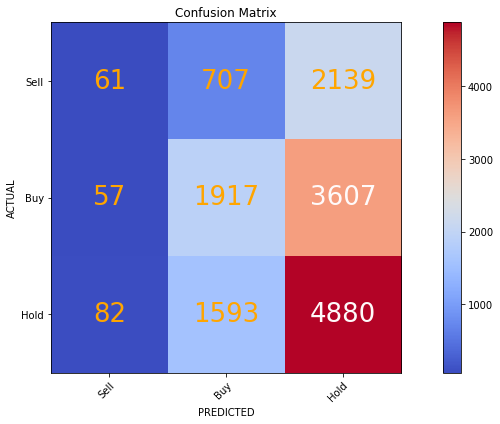

In [16]:
plot_confusion_matrix(y_test, s_pred, title="Confusion Matrix")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.show()